# Download
https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733

10X Single-cell RNA-seq data from microfluidic emulsion (v2)

SS2 Single-cell RNA-seq data from Smart-seq2 sequencing of FACS sorted cells (v2)

# Preprocess

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
tissue = "Lung"

data_path = "data_TM/" + tissue

if not os.path.exists(data_path):
    os.makedirs(data_path)

path_SS2 = "/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/FACS"
path_10X = "/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/droplet"

meta_SS2 = pd.read_csv("/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/annotations_facs.csv", 
                       keep_default_na=False)
meta_10X = pd.read_csv("/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/annotations_droplet.csv", 
                       keep_default_na=False)

# Read SS2 cell-by-gene counts
adata_SS2 = sc.read_csv(os.path.join(path_SS2, "%s-counts.csv" % tissue)).transpose()
ERCC_idx = pd.Series(adata_SS2.var.index).str.startswith('ERCC')
cell_idx = adata_SS2.obs.index.isin(meta_SS2[(meta_SS2.cell_ontology_class != 0) & 
                                             (meta_SS2.cell_ontology_class != "")].cell)
adata_SS2 = adata_SS2[cell_idx, -ERCC_idx]

# Read 10X cell-by-gene counts
channels = sorted(set(meta_10X[meta_10X.tissue == tissue].channel))
for i, channel in enumerate(channels):
    if i == 0:
        adata_10X = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                                    var_names='gene_symbols',cache=False)
        adata_10X.obs.index = channel + "_" + adata_10X.obs.index
        adata_10X.obs.index = adata_10X.obs.index.map(lambda x: x[:-2])
        cell_idx = adata_10X.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                                     (meta_10X.cell_ontology_class != "")].cell)
        adata_10X = adata_10X[cell_idx, :]
    else:
        tmp = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                              var_names='gene_symbols',cache=False)
        tmp.obs.index = channel + "_" + tmp.obs.index
        tmp.obs.index = tmp.obs.index.map(lambda x: x[:-2])
        cell_idx = tmp.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                               (meta_10X.cell_ontology_class != "")].cell)
        adata_10X = adata_10X.concatenate(tmp[cell_idx, :], index_unique=None)

celltype_SS2 = meta_SS2[meta_SS2.cell.isin(adata_SS2.obs.index)][["cell", "cell_ontology_class"]].set_index("cell")
celltype_SS2["method"] = "SS2"
celltype_10X = meta_10X[meta_10X.cell.isin(adata_10X.obs.index)][["cell", "cell_ontology_class"]].set_index("cell")
celltype_10X["method"] = "10X"
meta = pd.concat([celltype_SS2, celltype_10X]).rename(columns={"cell_ontology_class": "celltype"})
meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))

sc.pp.filter_cells(adata_SS2, min_genes=200)
sc.pp.filter_genes(adata_SS2, min_cells=3)
sc.pp.filter_cells(adata_10X, min_genes=200)
sc.pp.filter_genes(adata_10X, min_cells=3)

meta = pd.read_pickle(os.path.join(data_path, "meta_raw.pkl"))
meta = meta.loc[list(adata_SS2.obs.index) + list(adata_10X.obs.index), ]
meta.to_pickle(os.path.join(data_path, "meta.pkl"))

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Trying to set attribute `.obs` of view, copying.
filtered out 6148 genes that are detected in less than 3 cells
filtered out 7584 genes that are detected in less than 3 cells


# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Create a folder for saving results
result_path = "./result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Begining time:  Wed Dec 29 15:59:56 2021
step 0, loss_D=16.415739, loss_GAN=3.875703, loss_AE=554.637390, loss_cos=88.741280, loss_LA=450.855347
step 200, loss_D=2.146647, loss_GAN=4.708324, loss_AE=11.117537, loss_cos=7.114518, loss_LA=3.887704
step 400, loss_D=2.215403, loss_GAN=4.480033, loss_AE=5.576840, loss_cos=4.566592, loss_LA=1.867862
step 600, loss_D=1.803393, loss_GAN=4.176105, loss_AE=3.809077, loss_cos=3.771874, loss_LA=1.162866
step 800, loss_D=1.863636, loss_GAN=3.897865, loss_AE=3.311316, loss_cos=3.463433, loss_LA=0.934607
Ending time:  Wed Dec 29 16:00:21 2021
Training takes 24.53 seconds
Begining time:  Wed Dec 29 16:00:21 2021
Ending time:  Wed Dec 29 16:00:21 2021
Evaluating takes 0.05 seconds
UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Wed Dec 29 16:00:21 2021 Finding Nearest 

/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Wed Dec 29 16:00:31 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


... storing 'celltype' as categorical
... storing 'method' as categorical


Wed Dec 29 16:00:53 2021 Finished embedding


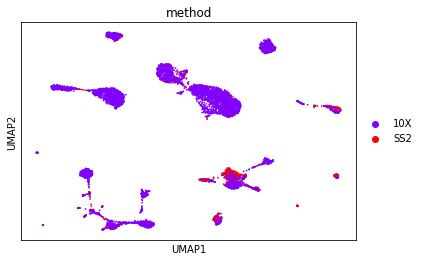

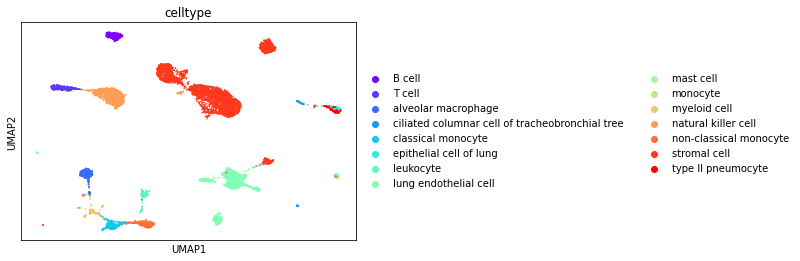

In [4]:
model = portal.model.Model(training_steps=1000, lambdacos=45.0)
model.preprocess(adata_SS2, adata_10X) # perform preprocess and PCA
model.train() # train the model
model.eval() # get integrated latent representation of cells

portal.utils.plot_UMAP(model.latent, meta, colors=["method", "celltype"], save=True, result_path=result_path)

In [5]:
# repreduce figure in paper

from sklearn import preprocessing
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl
import umap

meta = pd.read_pickle(os.path.join("data_TM/" + tissue, "meta.pkl"))

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.fit_transform(meta["method"].values)
colours = ListedColormap(["tab:blue", "tab:orange"])

rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new

le2 = preprocessing.LabelEncoder()
le2.fit(sorted(set(meta["celltype"])))
label2 = le.fit_transform(meta["celltype"].values)
colours2 = ListedColormap(rgb2hex_10)

reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(model.latent)

n_cells = embedding.shape[0]
if n_cells >= 15000:
    size = 120000 / n_cells
else:
    size = 8

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Wed Dec 29 16:00:55 2021 Finding Nearest Neighbors
Wed Dec 29 16:00:55 2021 Building RP forest with 9 trees
Wed Dec 29 16:00:55 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Wed Dec 29 16:00:56 2021 Finished Nearest Neighbor Search
Wed Dec 29 16:00:57 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec 29 16:01:19 2021 Finished embedding


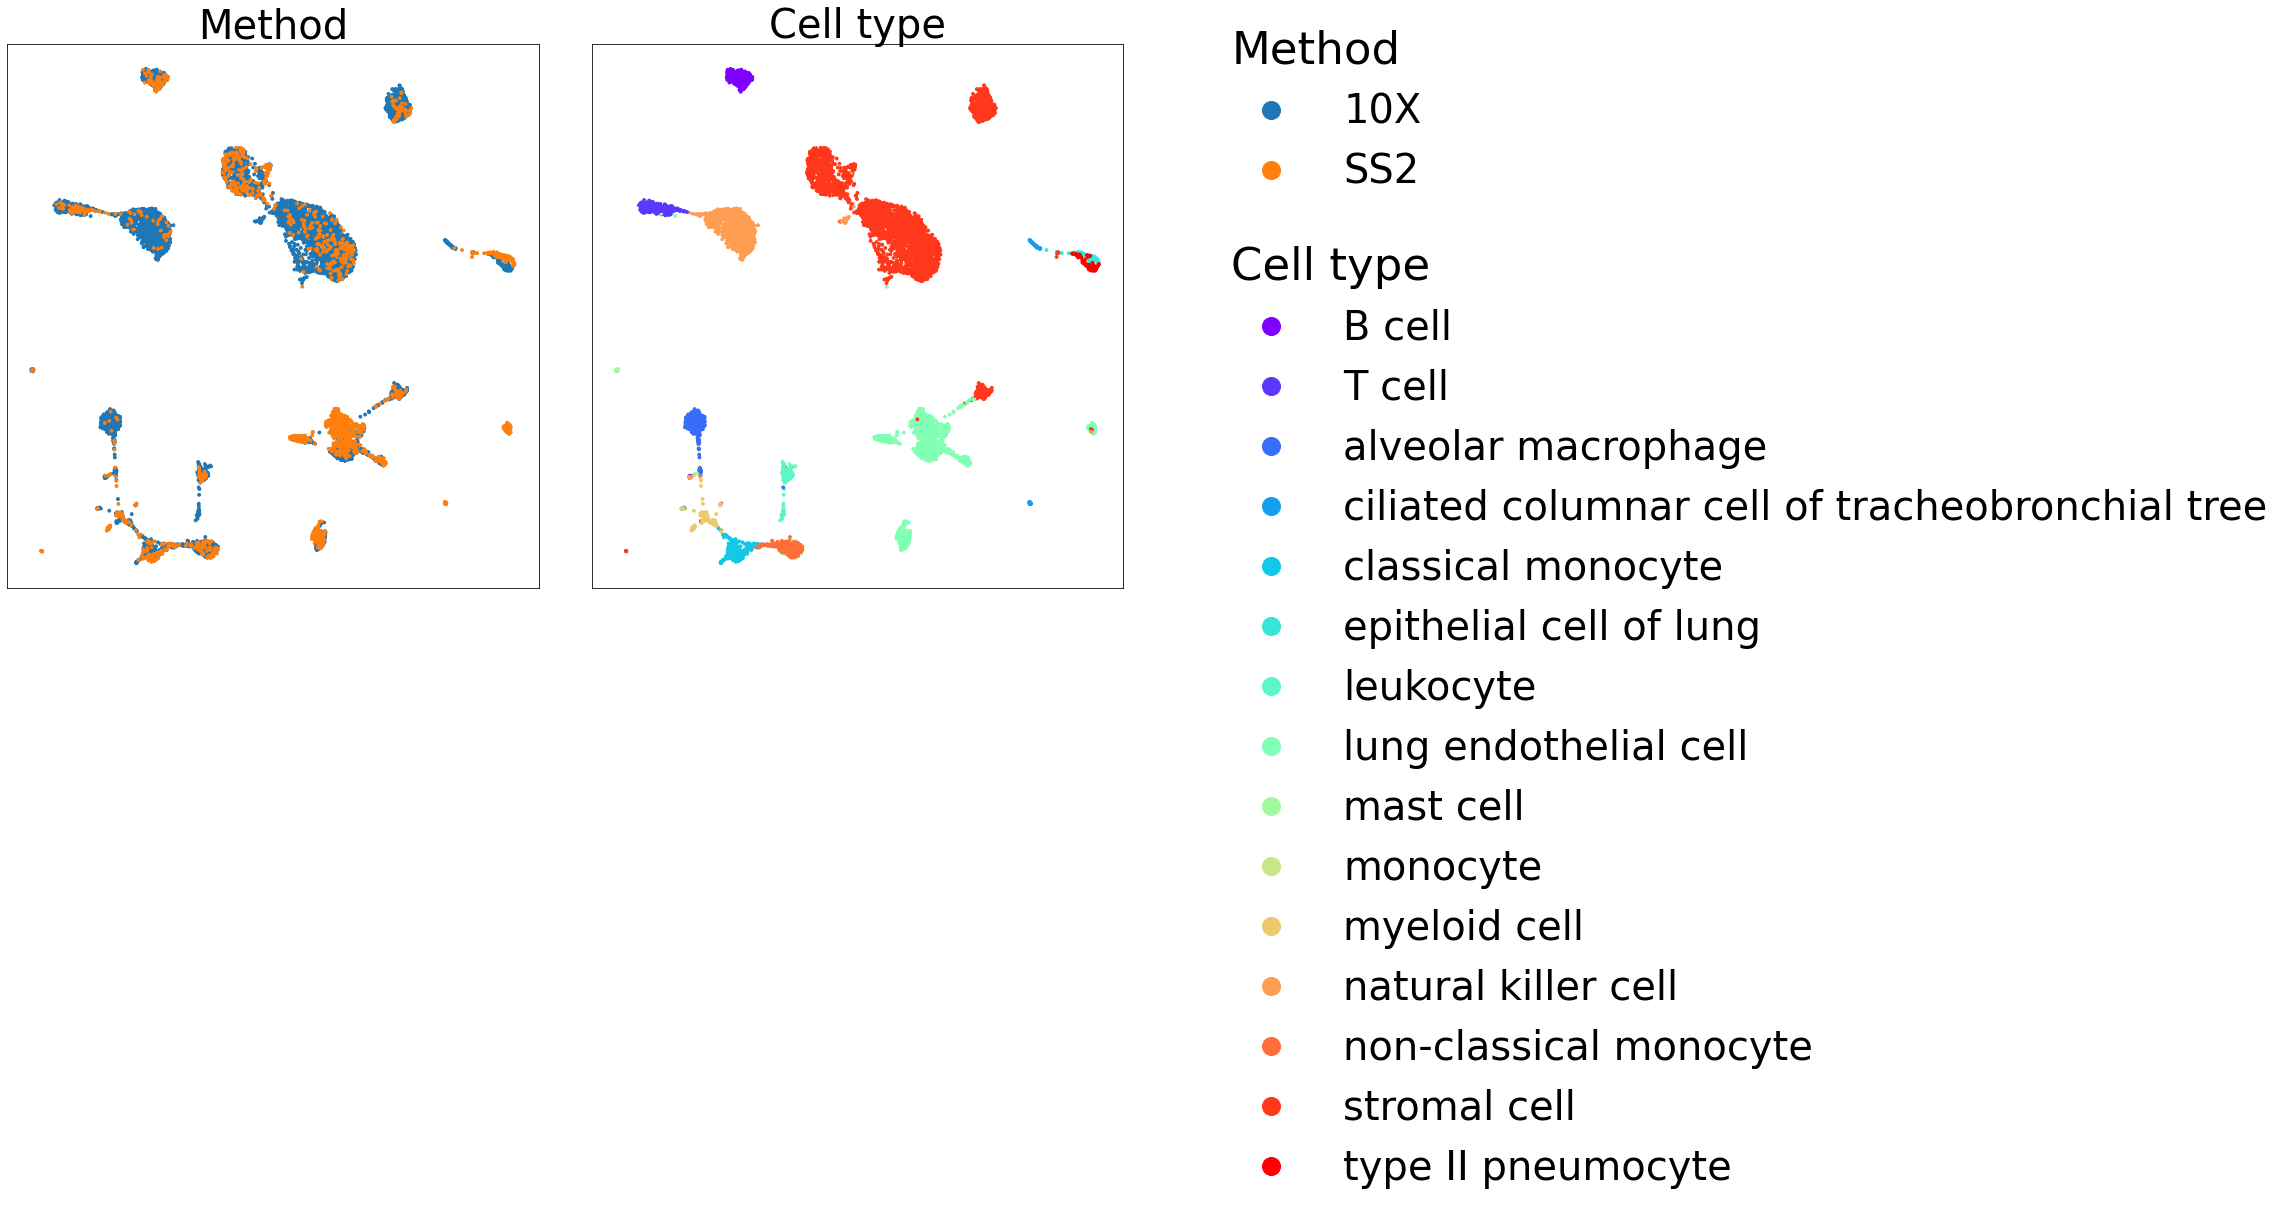

In [6]:
f = plt.figure(figsize=(20,10))

ax1 = f.add_subplot(1,2,1)
# Put SS2 data (fewer) on the top of the plot
scatter1 = ax1.scatter(embedding[:, 0][::-1], embedding[:, 1][::-1], s=size, c=label[::-1], cmap=colours, label=meta["method"].values[::-1])
ax1.set_title("Method", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2 = f.add_subplot(1,2,2)
scatter2 = ax2.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label2, cmap="rainbow", label=meta["celltype"].values)
ax2.set_title("Cell type", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter1.legend_elements()[0], labels=sorted(set(meta["method"])), loc="upper left", bbox_to_anchor=(0.95, 0.95), 
                    markerscale=3., title_fontsize=45, fontsize=40, frameon=False, ncol=1, title="Method")
l2 = f.legend(handles=scatter2.legend_elements(num=len(sorted(set(meta["celltype"])))-1)[0], labels=sorted(set(meta["celltype"])), loc="upper left", bbox_to_anchor=(0.95, 0.65), 
                    markerscale=3., title_fontsize=45, fontsize=40, frameon=False, ncol=1, title="Cell type")
l1._legend_box.align = "left"
l2._legend_box.align = "left"

f.subplots_adjust(hspace=.1, wspace=.1)

# Label transfer

In [7]:
from scipy.spatial import distance_matrix

In [8]:
pattern_10X = {'alveolar macrophage': 'Alveolar macrophage', 
               'ciliated columnar cell of tracheobronchial tree': 'Ciliated columnar cell of tracheobronchial tree',
               'classical monocyte': 'Classical monocyte', 'leukocyte': 'Leukocyte', 'lung endothelial cell': 'Lung endothelial cell',
               'mast cell': 'Mast cell', 'myeloid cell': 'Dendritic cell and interstital macrophage', 'natural killer cell': 'Natural killer cell',
               'non-classical monocyte': 'Non-classical monocyte', 'stromal cell': 'Stromal cell',
               'type II pneumocyte': 'Epithelial cell of lung', 'epithelial cell of lung': 'Epithelial cell of lung'}

pattern_SS2 = {'alveolar macrophage': 'Alveolar macrophage', 
               'ciliated columnar cell of tracheobronchial tree': 'Ciliated columnar cell of tracheobronchial tree',
               'classical monocyte': 'Classical monocyte', 'leukocyte': 'Leukocyte', 'lung endothelial cell': 'Lung endothelial cell',
               'mast cell': 'Mast cell', 'myeloid cell': 'Dendritic cell, alveolar macrophage, and interstital macrophage', 'natural killer cell': 'Natural killer cell',
               'non-classical monocyte': 'Non-classical monocyte', 'stromal cell': 'Stromal cell',
               'type II pneumocyte': 'Epithelial cell of lung', 'epithelial cell of lung': 'Epithelial cell of lung'}

label_SS2_old = list(meta[meta["method"]=="SS2"].celltype.replace("monocyte", "non-classical monocyte").values)
label_SS2_old = [pattern_SS2[x] if x in pattern_10X else x for x in label_SS2_old]
label_10X_new = list(meta[meta["method"]=="10X"].celltype.values)
label_10X_new = [pattern_10X[x] if x in pattern_SS2 else x for x in label_10X_new]

In [9]:
def annotate_by_nn(vec_tar, vec_ref, label_ref, k=20):
    dist_mtx = distance_matrix(vec_tar, vec_ref)
    idx = dist_mtx.argsort()[:, :k]
    labels = [max(list(label_ref[i]), key=list(label_ref[i]).count) for i in idx]
    return labels

In [10]:
latent_SS2 = model.latent[meta["method"]=="SS2"]
latent_10X = model.latent[meta["method"]=="10X"]

In [11]:
label_SS2_new = annotate_by_nn(vec_tar=latent_SS2, vec_ref=latent_10X, label_ref=np.array(label_10X_new))

In [12]:
sum(np.array(label_SS2_new).astype(str) == "Alveolar macrophage") / latent_SS2.shape[0]

0.007756563245823389

In [13]:
sum(np.array(label_SS2_new).astype(str) == "Dendritic cell and interstital macrophage") / latent_SS2.shape[0]

0.045942720763723154

In [14]:
sum(np.array(label_SS2_new).astype(str) == "Classical monocyte") / latent_SS2.shape[0]

0.04832935560859188

In [15]:
sum(np.array(label_SS2_new).astype(str) == "Non-classical monocyte") / latent_SS2.shape[0]

0.0405727923627685

In [16]:
sum([label_SS2_old[i]==label_SS2_new[i] for i in range(len(label_SS2_old))]) / latent_SS2.shape[0]

0.9194510739856802

In [17]:
set(label_SS2_new)

{'Alveolar macrophage',
 'B cell',
 'Ciliated columnar cell of tracheobronchial tree',
 'Classical monocyte',
 'Dendritic cell and interstital macrophage',
 'Epithelial cell of lung',
 'Leukocyte',
 'Lung endothelial cell',
 'Mast cell',
 'Natural killer cell',
 'Non-classical monocyte',
 'Stromal cell',
 'T cell'}

In [18]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.transform(meta["method"].values)
colours = ListedColormap(["tab:blue", "tab:orange"])

le2 = preprocessing.LabelEncoder()
ls2 = sorted(set(label_10X_new).union(set(label_SS2_old)))
le2.fit(ls2)
label_all = le2.transform(label_10X_new + label_SS2_old)
label_10X = le2.transform(label_10X_new)
label_SS2 = le2.transform(label_SS2_new)
colours2 = "rainbow"

label_SS2_o = le2.transform(label_SS2_old)
colours3 = "rainbow"

from pylab import *
cmap = cm.get_cmap("rainbow", 14)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

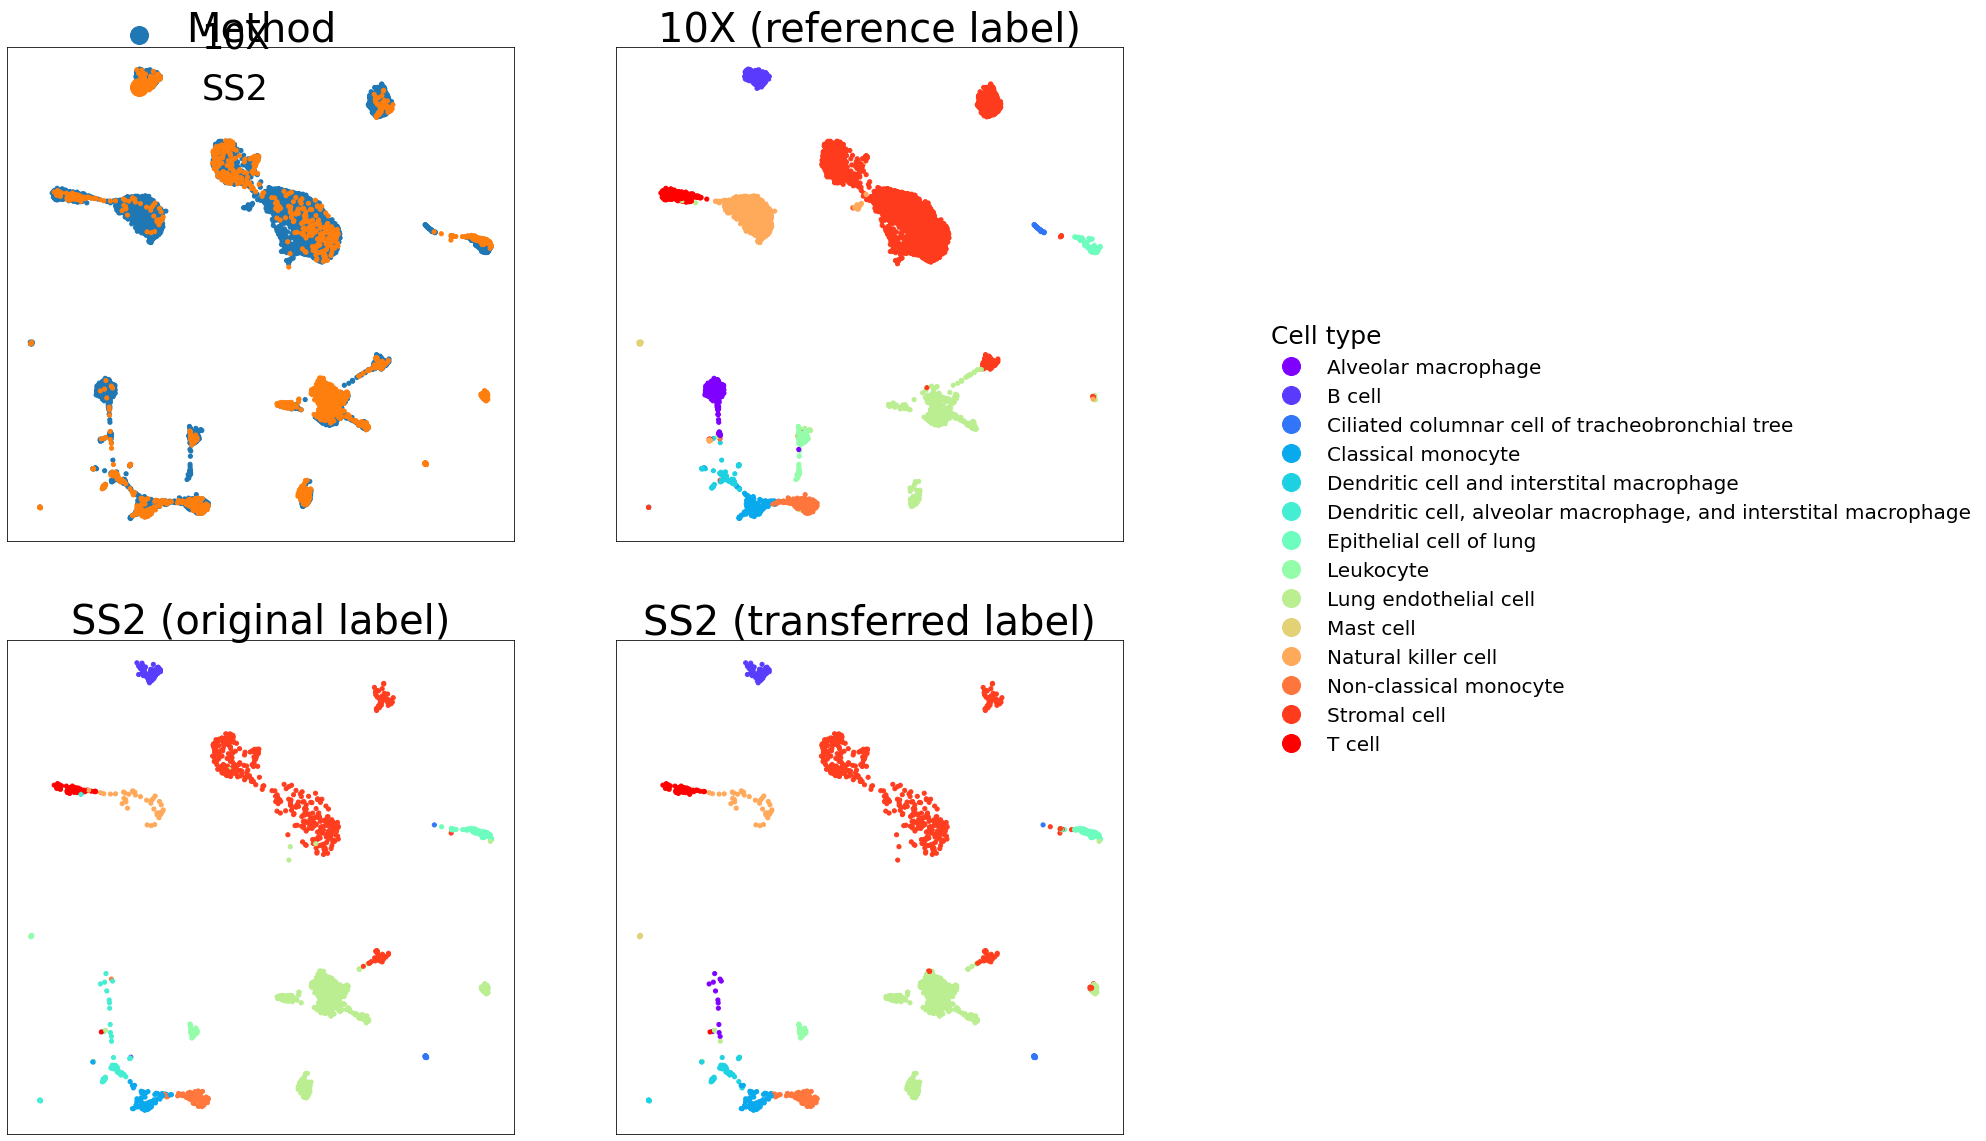

In [19]:
f = plt.figure(figsize=(20,20))

n_cells = embedding.shape[0]
size = 120000 / n_cells

# method

ax0 = f.add_subplot(2,2,1)
scatter0 = ax0.scatter(embedding[meta["celltype"].values.astype(str)!="nan", 0], 
                       embedding[meta["celltype"].values.astype(str)!="nan", 1], 
                       s=size, c=label_all, #[colors[i] for i in label_10X], 
                       cmap=colours2)
ax0.set_visible(False)


ax = f.add_subplot(2,2,1)
scatter = ax.scatter(embedding[meta["celltype"].values.astype(str)!="nan", 0][::-1], 
                       embedding[meta["celltype"].values.astype(str)!="nan", 1][::-1], 
                       s=size, c=label[::-1], #[colors[i] for i in label_10X], 
                       cmap=colours)
ax.set_title("Method", fontsize=40)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

# 10X
ax1 = f.add_subplot(2,2,2)
scatter1 = ax1.scatter(embedding[meta["celltype"].values.astype(str)!="nan", 0][meta["method"]=="10X"], 
                       embedding[meta["celltype"].values.astype(str)!="nan", 1][meta["method"]=="10X"], 
                       s=size, c=label_10X, #[colors[i] for i in label_10X], 
                       cmap=colours2)
ax1.set_title("10X (reference label)", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

# SS2_original
ax2 = f.add_subplot(2,2,3)
scatter2 = ax2.scatter(embedding[meta["celltype"].values.astype(str)!="nan", 0][meta["method"]=="SS2"], 
                       embedding[meta["celltype"].values.astype(str)!="nan", 1][meta["method"]=="SS2"], 
                       s=size, c=[colors[i] for i in label_SS2_o], 
                       cmap=colours2)
ax2.set_title("SS2 (original label)", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())


# SS2
ax3 = f.add_subplot(2,2, 4)
scatter3 = ax3.scatter(embedding[meta["celltype"].values.astype(str)!="nan", 0][meta["method"]=="SS2"], 
                       embedding[meta["celltype"].values.astype(str)!="nan", 1][meta["method"]=="SS2"], 
                       s=size, c=[colors[i] for i in label_SS2], 
                       cmap=colours2)
ax3.set_title("SS2 (transferred label)", fontsize=40)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())

l0 = f.legend(handles=scatter.legend_elements(num=len(sorted(set(label))))[0], labels=sorted(set(meta["method"].values)), loc="upper left", bbox_to_anchor=(0.17, 0.92), 
                    markerscale=3, title_fontsize=40, fontsize=35, frameon=False, ncol=1)
l = f.legend(handles=scatter0.legend_elements(num=len(sorted(set(label_10X_new).union(set(label_SS2_old)))))[0], labels=sorted(set(label_10X_new).union(set(label_SS2_old))), loc="upper left", bbox_to_anchor=(0.99, 0.7), 
                    markerscale=3, title_fontsize=25, fontsize=20, frameon=False, ncol=1, title="Cell type")
l._legend_box.align = "left"
f.subplots_adjust(hspace=.2, wspace=.2)
f.savefig("Umaps-%s.png" % tissue, bbox_inches='tight', dpi=100)

# DE

In [20]:
sc.pp.normalize_total(adata_SS2, target_sum=1e4)
sc.pp.log1p(adata_SS2)
sc.pp.scale(adata_SS2, max_value=10)
# adata_SS2.raw = adata_SS2

sc.pp.normalize_total(adata_10X, target_sum=1e4)
sc.pp.log1p(adata_10X)
sc.pp.scale(adata_10X, max_value=10)
# adata_10X.raw = adata_10X

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_new' as categorical


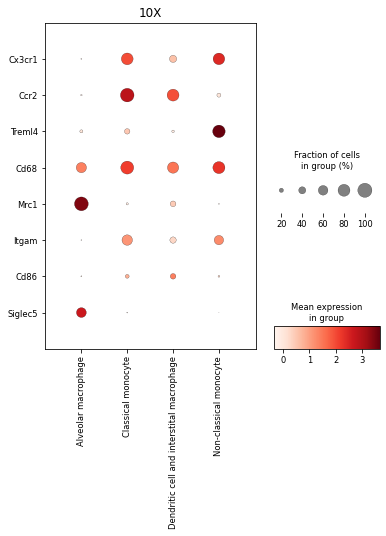

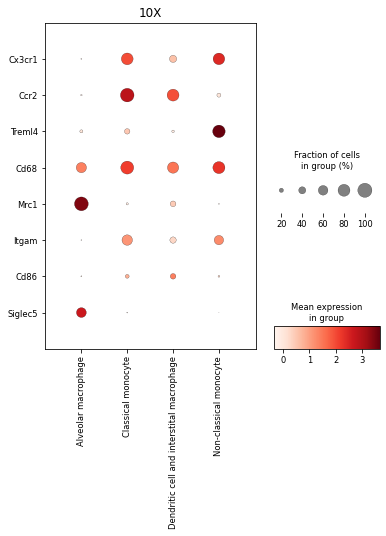

In [21]:
adata_10X.obs["cell_type_new"] = label_10X_new
markers = ["Cx3cr1","Ccr2","Treml4","Cd68","Mrc1","Itgam","Cd86","Siglec5"]
dp = sc.pl.dotplot(adata_10X[(adata_10X.obs["cell_type_new"] == "Alveolar macrophage") | 
                             (adata_10X.obs["cell_type_new"] == "Dendritic cell and interstital macrophage") | 
                             (adata_10X.obs["cell_type_new"] == "Classical monocyte") | 
                             (adata_10X.obs["cell_type_new"] == "Non-classical monocyte")], 
              markers, groupby='cell_type_new', 
              dendrogram=False, figsize=(6,6),
              title="10X",
              swap_axes=True,
                   use_raw=False,
              return_fig=True)
#               swap_axes=True,
#               save="Antoine_Bladder_10X_reference.pdf")

# print(dp)
# dp = sc.pl.dotplot(adata, markers, 'bulk_labels', return_fig=True)
dp.legend(width=2).show()
dp.savefig("Lung_reference.pdf")

/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_new' as categorical


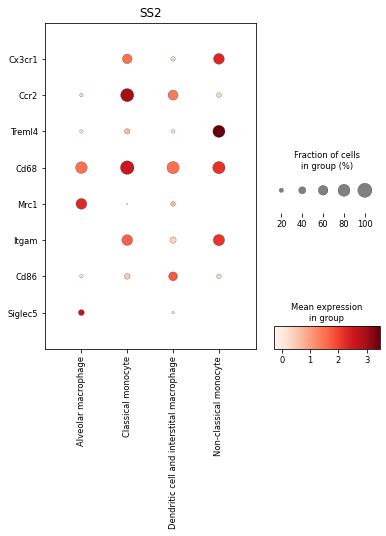

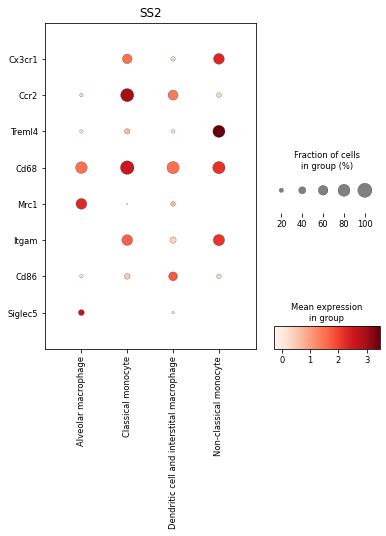

In [22]:
adata_SS2.obs["cell_type_new"] = label_SS2_new
markers = ["Cx3cr1","Ccr2","Treml4","Cd68","Mrc1","Itgam","Cd86","Siglec5"]
dp = sc.pl.dotplot(adata_SS2[(adata_SS2.obs["cell_type_new"] == "Alveolar macrophage") | 
                             (adata_SS2.obs["cell_type_new"] == "Dendritic cell and interstital macrophage") | 
                             (adata_SS2.obs["cell_type_new"] == "Classical monocyte") | 
                             (adata_SS2.obs["cell_type_new"] == "Non-classical monocyte")], 
              markers, groupby='cell_type_new', 
              dendrogram=False, figsize=(6,6),
              title="SS2",
              swap_axes=True,
              return_fig=True)
#               swap_axes=True,
#               save="Antoine_Bladder_10X_reference.pdf")

# print(dp)
# dp = sc.pl.dotplot(adata, markers, 'bulk_labels', return_fig=True)
dp.legend(width=2).show()
dp.savefig("Lung_transfer.pdf")